In [24]:
%config InlineBackend.rc = {"figure.dpi": 72, 'figure.figsize': (6.0, 4.0)}
%matplotlib inline

import ase
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

import abtem

abtem.config.set({"local_diagnostics.progress_bar": True});

(tutorial:visualizations)=
# Visualizations

Visualizing the results is an integral part of understanding the output of a scattering simulation. The *ab*TEM visualization module wraps the `matplotlib` library to more easily produce the typical visualizations needed when simulating electron microscopy, in this tutorial we cover how to customize the visualizations. We note that not every customization is possible within the framework of the *ab*TEM visulization module; it may sometimes be more practical to create your own visualization from scratch.

```{seealso}
This tutorial only covers static visualizations. The *ab*TEM visulization module also features [animated](tutorial:animations) and [interactive]() visualizations, see the respective tutorials for more information.
```

## Customizing an image ensemble

The *ab*TEM visualization module is based on the concept of ensembles, see the appendix for details. Given an object with one or more ensemble axes *ab*TEM
 will create an "exploded" plot when you set `explode=True`. The exploded plot shows a 1D or 2D grid of images or line plots, where each image or line plot represents a member in the ensemble.

We create HRTEM images for silicon $\{100\}$ with a single ensemble dimension representing different values of defocus.

In [32]:
atoms_cell = ase.build.bulk("Si", cubic=True)

atoms = atoms_cell * (1, 1, 100)

potential = abtem.Potential(atoms, sampling=0.05)

wave = abtem.PlaneWave(energy=200e3)

defocus = np.linspace(0, 100, 3)

measurements = wave.multislice(potential).apply_ctf(defocus=defocus).compute()

[########################################] | 100% Completed | 2.48 ss


We create a visualization using the `.show` method. We set `explode=True` to create an "exploded" grid plot. We set `common_color_scale=True` to show all the images on a single color scale, if this is set to `False` each image is scaled indepdently. We set `cbar=True` to included a colorbar and `cmap="gray"` to show the images using a grayscale colormap, see the `matplotlib` [documentation](https://matplotlib.org/stable/gallery/color/colormap_reference.html) for a full list of colormaps. 

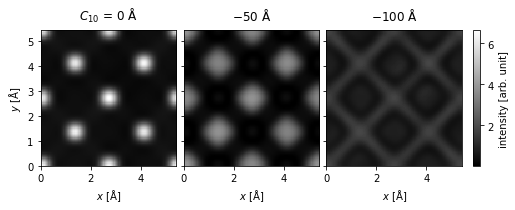

In [33]:
visualization = measurements.apply_ctf(semiangle_cutoff=30).show(
    explode=True,
    common_color_scale=True,
    figsize=(8, 8),
    cbar=True,
    cmap="gray",
)

The `.show` method produces a `MeasurementVisualization` object, the specific subtype will depend on the type of measurement object used to create the visualization. In this case, we obtain a `MeasurementVisualization2D` object.

In [28]:
visualization

The `MeasurementVisualization` objects wraps a matplotlib figure.

In [35]:
object.__repr__(visualization.fig)

'<matplotlib.figure.Figure object at 0x7fe9e39fd490>'

In [5]:
visualization.axes

We can convert the `AxesGrid` to a `numpy` array of matplotlib `Axes`. The `numpy` array is always 2D, in this case . The `Axes` can be customized 

In [36]:
np.array(visualization.axes).shape

(3, 1)

In [7]:
visualization.axes[0, 0]

<Axes: xlabel='$x$ [$\\mathrm{\\AA}$]', ylabel='$y$ [$\\mathrm{\\AA}$]'>

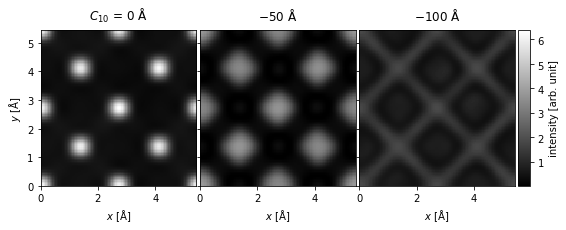

In [8]:
visualization.set_axes_padding((0.05, 0.0))
visualization.set_cbar_size(0.075)
visualization.set_cbar_padding((0.05, 0.0))

visualization.fig

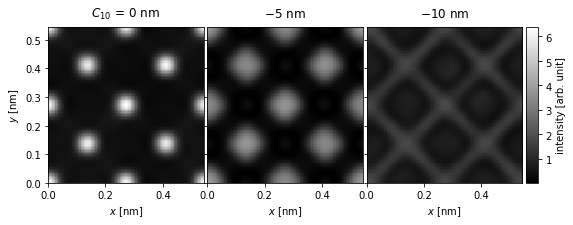

In [9]:
visualization.set_column_titles(units="nm")
visualization.set_x_units("nm")
visualization.set_y_units("nm")

visualization.fig

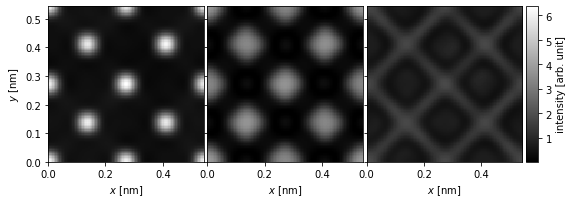

In [10]:
visualization.set_column_titles(titles="")

visualization.fig

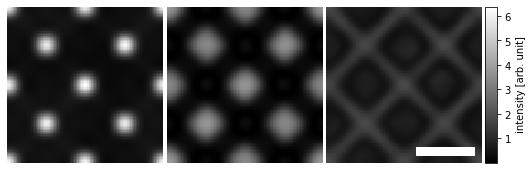

In [11]:
visualization.axis_off(spines=False)
visualization.set_sizebars(size=2, color="w")

visualization.fig

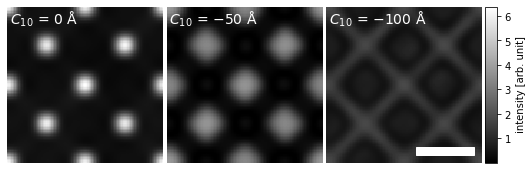

In [12]:
visualization.set_panel_labels(
    labels="metadata", frameon=False, prop={"fontsize": 14, "color": "w"}
)

visualization.fig

## Diffraction spots

In [13]:
atoms_cell = ase.build.bulk("Si", cubic=True)

atoms = atoms_cell * (1, 1, 10)

potential = abtem.Potential(atoms, sampling=0.05)

wave = abtem.PlaneWave(energy=200e3)

wave.grid.match(potential)

measurements = wave.multislice(potential).compute()

spots = measurements.diffraction_patterns().index_diffraction_spots(
    cell=atoms_cell.cell, threshold=1e-4
)

[########################################] | 100% Completed | 315.14 ms


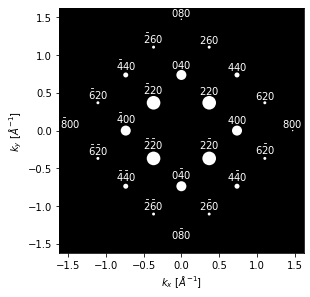

In [14]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(["w"])

visualization = (
    spots.crop(60)
    .block_direct()
    .show(
        explode=False,
        scale=.5,
        cmap=cmap,
        power=.5,
        common_color_scale=True,
        display=False,
    )
)

for ax in np.array(visualization.axes).ravel():
    ax.set_facecolor("k")

visualization.set_x_units(units="1/Å")
visualization.set_y_units(units="1/Å")

visualization.set_miller_index_annotations(0.00015, size=10, color="w")

visualization.fig

## 2D grids

In [15]:
defocus = np.linspace(-50, 50, 7)
Cs = np.linspace(0, 400000, 5)

atoms = ase.build.graphene(vacuum=2)

exit_wave = abtem.PlaneWave(energy=80e3, sampling=0.05).multislice(atoms)

focal_spread = 30
defocus_distribution = abtem.distributions.gaussian(
    center=0.0,
    standard_deviation=focal_spread,
    num_samples=101,
    sampling_limit=2,
)

images = (
    exit_wave.apply_ctf(defocus=defocus, Cs=Cs)
    .apply_ctf(defocus=defocus_distribution)
    .intensity()
    .sum(0)
    .compute()
)

[########################################] | 100% Completed | 828.71 ms


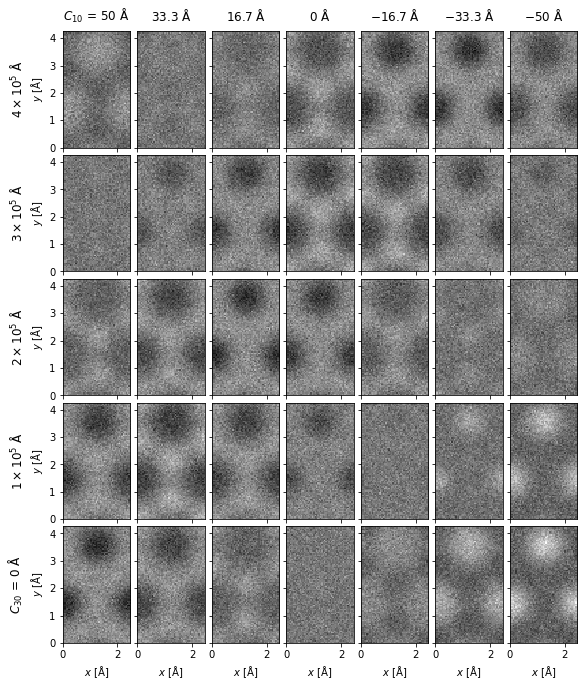

In [16]:
visualization = images.poisson_noise(5e5).show(
    explode=True, figsize=(10, 10), common_color_scale=True, cmap="gray"
)

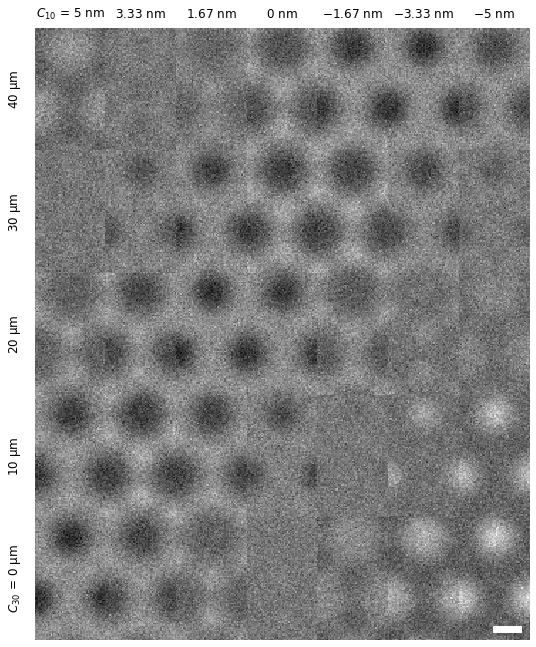

In [17]:
visualization.set_axes_padding([0.0, 0.0])
visualization.axis_off(spines=False)
visualization.set_row_titles(units="um")
visualization.set_column_titles(units="nm")
visualization.set_sizebars(size=1, color="w")

visualization.fig

## Domain coloring

The phase and amplitude can be display simultaneously using a technique called domain coloring

In [18]:
probe = abtem.Probe(
    semiangle_cutoff=30,
    defocus=60,
    astigmatism=np.linspace(0, 70, 3),
    astigmatism_angle=np.pi / 4,
    gpts=256,
    extent=20,
    energy=200e3,
)
probes = probe.build().complex_images().compute()

[########################################] | 100% Completed | 204.60 ms


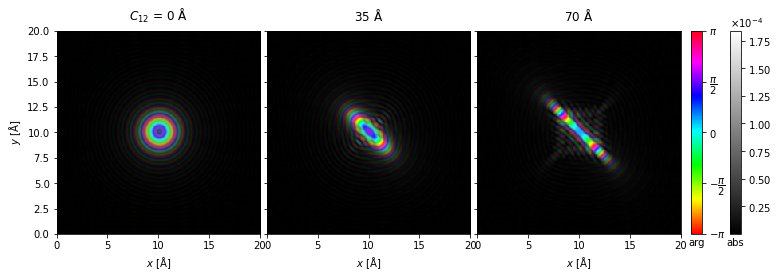

In [19]:
visualization = probes.show(
    explode=True, figsize=(12, 6), cbar=True, common_color_scale=True, cmap="hsv"
)

In [20]:
diffraction_patterns = (
    probe.build((0, 0)).diffraction_patterns(return_complex=True).crop(30)
)

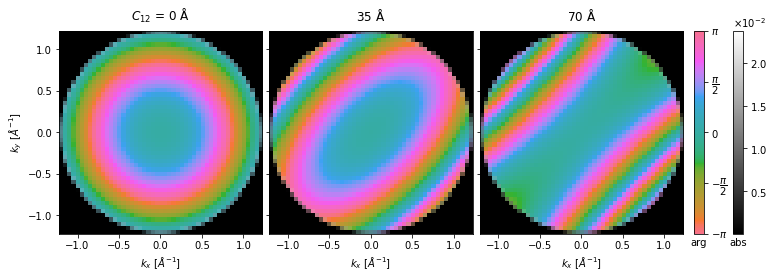

In [21]:
visualization = diffraction_patterns.show(
    explode=True, figsize=(12, 6), cbar=True, common_color_scale=True, cmap="hsluv"
)